# Knowledge Distillation for LLM Inference: Compressing Large Models for Production

This notebook replicates the implementation from the blog post: "Knowledge Distillation for LLM Inference: Compressing Large Models for Production"

We'll train a DistilBERT student model to mimic a fine-tuned BERT teacher model on the SST-2 sentiment analysis task from GLUE. The notebook includes evaluation functions to compare model performance before and after distillation.

In [1]:
# Install required packages
%pip install transformers datasets evaluate torch bitsandbytes accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 1: Load and Preprocess Data

We'll use the SST-2 dataset from GLUE, which is a binary sentiment classification task.

In [3]:
# Load SST-2 dataset from GLUE
print("Loading SST-2 dataset...")
dataset = load_dataset('glue', 'sst2')

# Load tokenizer from the teacher model
teacher_id = 'textattack/bert-base-uncased-SST-2'
tokenizer_teacher = AutoTokenizer.from_pretrained(teacher_id)

def preprocess(examples):
    """Tokenize the sentences"""
    return tokenizer_teacher(
        examples['sentence'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

# Preprocess the dataset
print("Preprocessing dataset...")
encoded = dataset.map(preprocess, batched=True)
encoded = encoded.rename_column('label', 'labels')
encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_dataset = encoded['train']
eval_dataset = encoded['validation']

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

Loading SST-2 dataset...


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Preprocessing dataset...


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Train samples: 67349
Validation samples: 872


## Step 2: Load Teacher and Student Models

- **Teacher**: Fine-tuned BERT model (textattack/bert-base-uncased-SST-2)
- **Student**: DistilBERT base model (distilbert-base-uncased)

In [4]:
# Load Teacher Model
print("Loading teacher model...")
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_id)
teacher_model.to(device)
teacher_model.eval()
print(f"Teacher model: {teacher_id}")

# Load Student Model
print("Loading student model...")
student_id = 'distilbert-base-uncased'
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_id,
    num_labels=teacher_model.config.num_labels,
    id2label=teacher_model.config.id2label,
    label2id=teacher_model.config.label2id
)
student_model.to(device)
print(f"Student model: {student_id}")

# Print model sizes
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)
print(f"\nTeacher parameters: {teacher_params:,}")
print(f"Student parameters: {student_params:,}")
print(f"Compression ratio: {teacher_params/student_params:.2f}x")

Loading teacher model...


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Teacher model: textattack/bert-base-uncased-SST-2
Loading student model...


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Student model: distilbert-base-uncased

Teacher parameters: 109,483,778
Student parameters: 66,955,010
Compression ratio: 1.64x


## Step 3: Evaluation Function

Function to evaluate model performance before and after distillation.

In [5]:
# Load accuracy metric
metric = evaluate.load('accuracy')

def evaluate_model(model, tokenizer, dataset, batch_size=32, device='cpu'):
    """
    Evaluate a model on a dataset.

    Args:
        model: The model to evaluate
        tokenizer: Tokenizer for the model
        dataset: Dataset to evaluate on
        batch_size: Batch size for evaluation
        device: Device to run evaluation on

    Returns:
        Dictionary with accuracy and other metrics
    """
    model.eval()
    model.to(device)

    loader = DataLoader(dataset, batch_size=batch_size)
    all_preds = []
    all_labels = []

    print(f"Evaluating model on {len(dataset)} samples...")
    for batch in tqdm(loader, desc="Evaluating"):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = metric.compute(predictions=all_preds, references=all_labels)

    return accuracy

## Step 4: Evaluate Models Before Distillation

In [6]:
# Evaluate teacher model
print("=" * 60)
print("EVALUATION BEFORE DISTILLATION")
print("=" * 60)

print("\n📊 Teacher Model Accuracy (before distillation):")
acc_teacher_before = evaluate_model(teacher_model, tokenizer_teacher, eval_dataset, device=device)
print(f"Accuracy: {acc_teacher_before['accuracy']:.4f} ({acc_teacher_before['accuracy']*100:.2f}%)")

print("\n📊 Untrained Student Model Accuracy (before distillation):")
acc_student_before = evaluate_model(student_model, tokenizer_teacher, eval_dataset, device=device)
print(f"Accuracy: {acc_student_before['accuracy']:.4f} ({acc_student_before['accuracy']*100:.2f}%)")

print("\n" + "=" * 60)

EVALUATION BEFORE DISTILLATION

📊 Teacher Model Accuracy (before distillation):
Evaluating model on 872 samples...


Evaluating: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]


Accuracy: 0.9243 (92.43%)

📊 Untrained Student Model Accuracy (before distillation):
Evaluating model on 872 samples...


Evaluating: 100%|██████████| 28/28 [00:02<00:00, 11.11it/s]

Accuracy: 0.4908 (49.08%)



## Step 5: Custom Distillation Trainer

We'll create a custom trainer that implements knowledge distillation loss, combining:
- **Distillation Loss**: KL divergence between teacher and student softmax outputs (with temperature)
- **Hard Label Loss**: Cross-entropy loss on ground truth labels
- **Combined Loss**: Weighted combination of both losses

In [7]:
class DistillationTrainer(Trainer):
    """
    Custom trainer for knowledge distillation.

    Combines:
    - Hard label loss (cross-entropy with ground truth)
    - Soft label loss (KL divergence with teacher predictions)
    """

    def __init__(self, teacher_model, temperature=4.0, alpha=0.5, *args, **kwargs):
        """
        Args:
            teacher_model: The teacher model to distill from
            temperature: Temperature for softmax (higher = softer probabilities)
            alpha: Weight for hard label loss (1-alpha for distillation loss)
        """
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.temperature = temperature
        self.alpha = alpha
        # Set teacher to eval mode
        self.teacher_model.eval()

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Compute the combined distillation loss.
        """
        # Forward pass through student model
        outputs_student = model(**inputs)

        # Forward pass through teacher model (no gradients)
        with torch.no_grad():
            outputs_teacher = self.teacher_model(**inputs)

        # Distillation loss: KL divergence between teacher and student
        # Apply temperature scaling to soften the probabilities
        loss_distill = F.kl_div(
            F.log_softmax(outputs_student.logits / self.temperature, dim=1),
            F.softmax(outputs_teacher.logits / self.temperature, dim=1),
            reduction='batchmean'
        ) * (self.temperature ** 2)  # Scale by temperature squared

        # Hard label loss: standard cross-entropy
        loss_ce = outputs_student.loss

        # Combined loss: weighted sum
        loss = self.alpha * loss_ce + (1.0 - self.alpha) * loss_distill

        return (loss, outputs_student) if return_outputs else loss

## Step 6: Train Student Model with Knowledge Distillation

In [8]:
# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    """
    Compute accuracy metric during evaluation.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir='./distilled_student',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_steps=100,
    report_to='none',  # Disable wandb/tensorboard
)

# Create distillation trainer
trainer = DistillationTrainer(
    teacher_model=teacher_model,
    model=student_model,
    args=training_args,
    train_dataset=train_dataset.select(range(1000)),
    eval_dataset=eval_dataset,
    tokenizer=tokenizer_teacher,
    compute_metrics=compute_metrics,
    temperature=2.0,  # Temperature for softmax
    alpha=0.5,  # Weight for hard label loss (0.5 = equal weight)
)

print("Starting knowledge distillation training...")
print(f"Temperature: {trainer.temperature}")
print(f"Alpha (hard label weight): {trainer.alpha}")
print(f"Distillation weight: {1.0 - trainer.alpha}")
print("\n" + "=" * 60)

# Train the model
trainer.train()

Starting knowledge distillation training...
Temperature: 2.0
Alpha (hard label weight): 0.5
Distillation weight: 0.5



Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.573328,0.846330
2,0.693000,0.561275,0.840596
3,0.693000,0.588612,0.875000


TrainOutput(global_step=189, training_loss=0.47463516961960567, metrics={'train_runtime': 92.7247, 'train_samples_per_second': 32.354, 'train_steps_per_second': 2.038, 'total_flos': 99350548992000.0, 'train_loss': 0.47463516961960567, 'epoch': 3.0})

## Step 7: Evaluate Models After Distillation

In [9]:
# Evaluate after distillation
print("=" * 60)
print("EVALUATION AFTER DISTILLATION")
print("=" * 60)

print("\n📊 Teacher Model Accuracy (unchanged):")
acc_teacher_after = evaluate_model(teacher_model, tokenizer_teacher, eval_dataset, device=device)
print(f"Accuracy: {acc_teacher_after['accuracy']:.4f} ({acc_teacher_after['accuracy']*100:.2f}%)")

print("\n📊 Distilled Student Model Accuracy (after distillation):")
acc_student_after = evaluate_model(trainer.model, tokenizer_teacher, eval_dataset, device=device)
print(f"Accuracy: {acc_student_after['accuracy']:.4f} ({acc_student_after['accuracy']*100:.2f}%)")

print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"\nTeacher Model:")
print(f"  Before: {acc_teacher_before['accuracy']*100:.2f}%")
print(f"  After:  {acc_teacher_after['accuracy']*100:.2f}%")

print(f"\nStudent Model:")
print(f"  Before distillation: {acc_student_before['accuracy']*100:.2f}%")
print(f"  After distillation:  {acc_student_after['accuracy']*100:.2f}%")
print(f"  Improvement:         {(acc_student_after['accuracy'] - acc_student_before['accuracy'])*100:.2f}%")

print(f"\nTeacher vs Student:")
print(f"  Accuracy gap: {(acc_teacher_after['accuracy'] - acc_student_after['accuracy'])*100:.2f}%")
print(f"  Compression:  {teacher_params/student_params:.2f}x smaller")
print("=" * 60)

EVALUATION AFTER DISTILLATION

📊 Teacher Model Accuracy (unchanged):
Evaluating model on 872 samples...


Evaluating: 100%|██████████| 28/28 [00:05<00:00,  5.25it/s]


Accuracy: 0.9243 (92.43%)

📊 Distilled Student Model Accuracy (after distillation):
Evaluating model on 872 samples...


Evaluating: 100%|██████████| 28/28 [00:02<00:00, 10.68it/s]

Accuracy: 0.8750 (87.50%)

COMPARISON SUMMARY

Teacher Model:
  Before: 92.43%
  After:  92.43%

Student Model:
  Before distillation: 49.08%
  After distillation:  87.50%
  Improvement:         38.42%

Teacher vs Student:
  Accuracy gap: 4.93%
  Compression:  1.64x smaller


## Step 8: Inference Examples

Test the distilled model on sample sentences.

In [10]:
def predict(texts, model, tokenizer, device='cpu'):
    """
    Predict sentiment for a list of texts.

    Args:
        texts: List of text strings
        model: Model to use for prediction
        tokenizer: Tokenizer for the model
        device: Device to run inference on

    Returns:
        List of predicted labels
    """
    model.eval()
    model.to(device)

    # Tokenize
    encodings = tokenizer(
        texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )

    # Remove token_type_ids if present (not needed for DistilBERT)
    if 'token_type_ids' in encodings:
        del encodings['token_type_ids']

    # Move to device
    encodings = {k: v.to(device) for k, v in encodings.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**encodings)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    # Map to labels
    label_map = model.config.id2label
    probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()
    class_probab = max(probabilities[0])

    return ([label_map[int(p)] for p in preds][0], class_probab)

# Test on sample sentences
test_sentences = [
    "The movie was overly long and boring.",
    "An absolute masterpiece of cinema!",
    "It was okay, not great but not terrible either.",
    "This film is a complete waste of time.",
    "I loved every minute of this incredible story.",
    "The acting was mediocre at best.",
]

print("Sample Predictions with Distilled Student Model:")
print("=" * 60)
for text in test_sentences:
    prediction, probab = predict([text], trainer.model, tokenizer_teacher, device=device)
    print(f"\nText: {text}")
    print(f"Prediction: {'NEGATIVE' if '0' in prediction else 'POSITIVE'}, with confidence {probab:.4f}")

print("\n" + "=" * 60)

Sample Predictions with Distilled Student Model:

Text: The movie was overly long and boring.
Prediction: NEGATIVE, with confidence 0.9970

Text: An absolute masterpiece of cinema!
Prediction: POSITIVE, with confidence 0.9986

Text: It was okay, not great but not terrible either.
Prediction: NEGATIVE, with confidence 0.8409

Text: This film is a complete waste of time.
Prediction: NEGATIVE, with confidence 0.9970

Text: I loved every minute of this incredible story.
Prediction: POSITIVE, with confidence 0.9984

Text: The acting was mediocre at best.
Prediction: NEGATIVE, with confidence 0.9944



## Optional: Save the Distilled Model

You can save the distilled student model for later use.

In [11]:
# Save the distilled model and tokenizer
save_path = '/content/distilled_student_final'
trainer.model.save_pretrained(save_path)
tokenizer_teacher.save_pretrained(save_path)
print(f"Model saved to: {save_path}")

# To load later:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

Model saved to: /content/distilled_student_final


# Compare student vs teacher

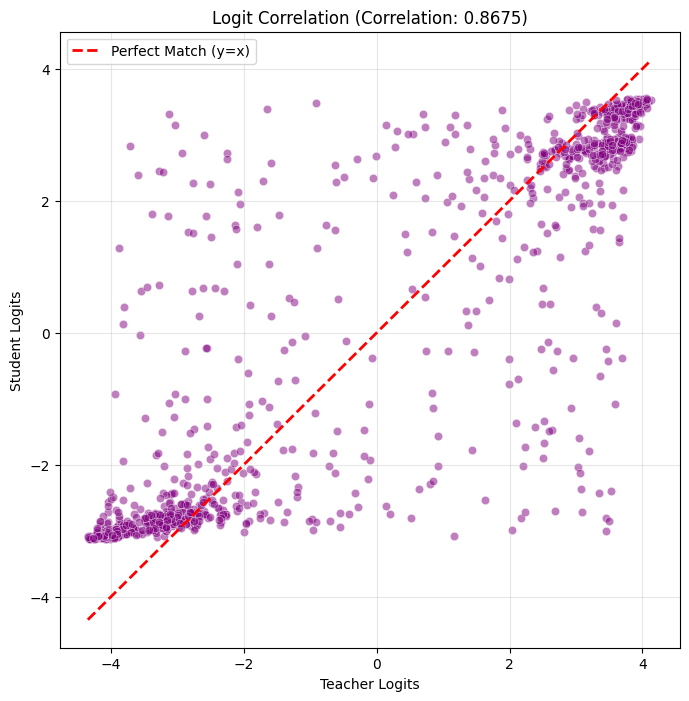

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

def plot_logit_correlation(teacher, student, dataset, device, num_samples=200):
    """
    Plots the correlation between Teacher and Student logits to verify distillation.
    Uses pre-tokenized 'input_ids' from the dataset to avoid KeyErrors.
    """
    teacher.eval()
    student.eval()

    # Create a small dataloader for inference
    subset = dataset.select(range(min(num_samples, len(dataset))))
    loader = DataLoader(subset, batch_size=32)

    teacher_logits_list = []
    student_logits_list = []

    print(f"Collecting logits for {len(subset)} samples...")

    with torch.no_grad():
        for batch in loader:
            # Move pre-tokenized inputs to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Get logits directly
            t_out = teacher(input_ids=input_ids, attention_mask=attention_mask)
            s_out = student(input_ids=input_ids, attention_mask=attention_mask)

            # Store logits
            teacher_logits_list.append(t_out.logits.cpu().numpy())
            student_logits_list.append(s_out.logits.cpu().numpy())

    # Flatten
    teacher_logits = np.concatenate(teacher_logits_list, axis=0).flatten()
    student_logits = np.concatenate(student_logits_list, axis=0).flatten()

    # Plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=teacher_logits, y=student_logits, alpha=0.5, color='purple')

    # Plot y=x line (Perfect distillation)
    min_val = min(teacher_logits.min(), student_logits.min())
    max_val = max(teacher_logits.max(), student_logits.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match (y=x)')

    plt.title(f"Logit Correlation (Correlation: {np.corrcoef(teacher_logits, student_logits)[0,1]:.4f})")
    plt.xlabel("Teacher Logits")
    plt.ylabel("Student Logits")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- RUN THE PLOT ---
# Note: We removed 'tokenizer' from the arguments since we don't need it anymore
plot_logit_correlation(teacher_model, trainer.model, eval_dataset, device,num_samples=500)

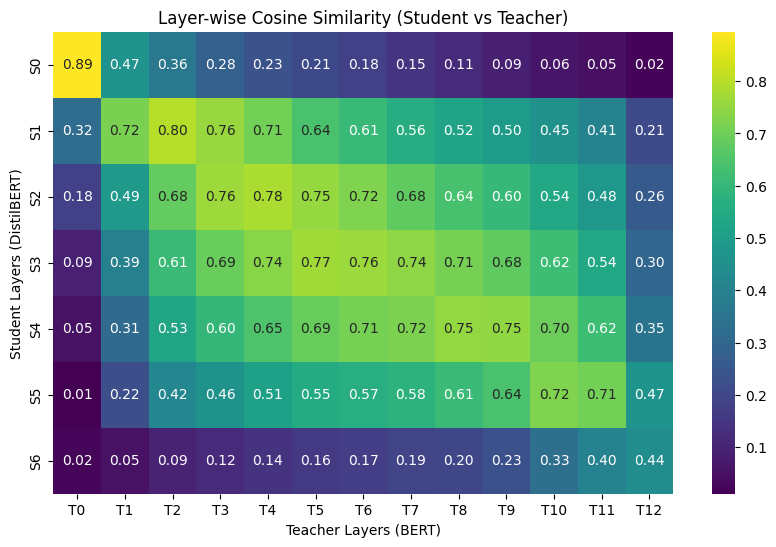

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

def plot_layer_similarity(teacher, student, dataset, device, num_samples=10):
    """
    Computes and plots the cosine similarity between every layer of the Teacher
    and every layer of the Student.
    """
    teacher.eval()
    student.eval()

    # Use DataLoader to safely fetch a batch of tensors
    # This avoids the "TypeError" by letting the library handle the collation
    subset = dataset.select(range(num_samples))
    loader = DataLoader(subset, batch_size=num_samples) # Load all samples in one batch

    # Get the single batch
    batch = next(iter(loader))

    # Move to device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        # output_hidden_states=True forces the model to return internal representations
        t_out = teacher(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        s_out = student(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

    # Hidden states tuple: (batch, seq_len, hidden_dim)
    t_hidden = t_out.hidden_states
    s_hidden = s_out.hidden_states

    num_t_layers = len(t_hidden)
    num_s_layers = len(s_hidden)

    similarity_matrix = np.zeros((num_s_layers, num_t_layers))

    # Compute similarity matrix
    for i in range(num_s_layers):
        for j in range(num_t_layers):
            # Flatten to (batch * seq_len, hidden_dim) to compare all tokens
            s_vec = s_hidden[i].reshape(-1, s_hidden[i].size(-1))
            t_vec = t_hidden[j].reshape(-1, t_hidden[j].size(-1))

            # Check dimensions (BERT base and DistilBERT base match at 768)
            if s_vec.shape[1] == t_vec.shape[1]:
                sim = F.cosine_similarity(s_vec, t_vec, dim=-1).mean().item()
                similarity_matrix[i, j] = sim
            else:
                similarity_matrix[i, j] = 0.0

    # Plot Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=[f"T{j}" for j in range(num_t_layers)],
                yticklabels=[f"S{i}" for i in range(num_s_layers)])

    plt.title("Layer-wise Cosine Similarity (Student vs Teacher)")
    plt.xlabel("Teacher Layers (BERT)")
    plt.ylabel("Student Layers (DistilBERT)")
    plt.show()

# --- RUN THE PLOT ---
plot_layer_similarity(teacher_model, trainer.model, eval_dataset, device)

In [14]:
#Prepare for downloading the model locally
!zip -r /content/distillated_student_model.zip /content/distilled_student_final

  adding: content/distilled_student_final/ (stored 0%)
  adding: content/distilled_student_final/special_tokens_map.json (deflated 42%)
  adding: content/distilled_student_final/model.safetensors (deflated 8%)
  adding: content/distilled_student_final/tokenizer.json (deflated 71%)
  adding: content/distilled_student_final/vocab.txt (deflated 53%)
  adding: content/distilled_student_final/config.json (deflated 45%)
  adding: content/distilled_student_final/tokenizer_config.json (deflated 75%)
